# Import Library

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define facies colors, label

In [0]:
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

# Define confusion matrix

In [0]:
def plot_confusion_matrix(conf, cmap=plt.cm.Blues):
    cm = conf
    classes = facies_labels
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Accuracy adjacent

In [0]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            if j< nb_classes: ##
                total_correct += conf[i][j] 
    return total_correct / sum(sum(conf))

# Import Drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
cd /content/gdrive/My\ Drive/UAE2019/Facies/

/content/gdrive/My Drive/UAE2019/Facies


In [7]:
ls

aa.png            ex2_Facies_xgboost.ipynb        old/           train_data.csv
ex1_Facies.ipynb  ex3_Facies_augumentation.ipynb  test_data.csv


# Define data augumentation

We procceed to run Paolo Bestagini's routine to include a small window of values to acount for the spatial component in the log analysis, as well as the gradient information with respect to depth. This will be our prepared training dataset.

In [0]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad


# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

# Train data, Data augumentaion

In [0]:
#Load Data
data = pd.read_csv('train_data.csv')

X = data[feature_names].values 
y = data['Facies'].values 

# Store well labels and depths
well = data['Well Name'].values
depth = data['Depth'].values

X_aug, padded_rows = augment_features(X, well, depth)

X_aug = np.delete(X_aug, padded_rows, axis=0)
y_aug = np.delete(y, padded_rows, axis=0)

# Check Data augumentation

In [13]:
pd.DataFrame(X, columns=feature_names).head(5)

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.45,0.664,9.9,11.915,4.6,1.0,1.000
1,78.26,0.661,14.2,12.565,4.1,1.0,0.979
2,79.05,0.658,14.8,13.050,3.6,1.0,0.957
3,86.10,0.655,13.9,13.115,3.5,1.0,0.936
4,74.58,0.647,13.5,13.300,3.4,1.0,0.915


In [16]:
dataaug = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', '1', '2', '3', '4', '5', '6', '7', 
           '8', '9', '10', '11', '12', '13', '14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']
pd.DataFrame(X_aug, columns=dataaug).head(5)

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,1,2,3,4,5,6,7,8,9,10,11,12,13,14,D1,D2,D3,D4,D5,D6,D7
0,77.45,0.664,9.9,11.915,4.6,1.0,1.000,78.26,0.661,14.2,12.565,4.1,1.0,0.979,79.05,0.658,14.8,13.050,3.6,1.0,0.957,1.58,-0.006,1.2,0.97,-1.0,0.0,-0.044
1,78.26,0.661,14.2,12.565,4.1,1.0,0.979,79.05,0.658,14.8,13.050,3.6,1.0,0.957,86.10,0.655,13.9,13.115,3.5,1.0,0.936,14.10,-0.006,-1.8,0.13,-0.2,0.0,-0.042
2,79.05,0.658,14.8,13.050,3.6,1.0,0.957,86.10,0.655,13.9,13.115,3.5,1.0,0.936,74.58,0.647,13.5,13.300,3.4,1.0,0.915,-23.04,-0.016,-0.8,0.37,-0.2,0.0,-0.042
3,86.10,0.655,13.9,13.115,3.5,1.0,0.936,74.58,0.647,13.5,13.300,3.4,1.0,0.915,73.97,0.636,14.0,13.385,3.6,1.0,0.894,-1.22,-0.022,1.0,0.17,0.4,0.0,-0.042
4,74.58,0.647,13.5,13.300,3.4,1.0,0.915,73.97,0.636,14.0,13.385,3.6,1.0,0.894,73.72,0.630,15.6,13.930,3.7,1.0,0.872,-0.50,-0.012,3.2,1.09,0.2,0.0,-0.044


# Test data

In [0]:
test = pd.read_csv('test_data.csv')

X_t = test[feature_names].values 
y_t = test['Facies'].values 

# Store well labels and depths
well_t = test['Well Name'].values
depth_t = test['Depth'].values

X_aug_t, padded_rows_t = augment_features(X_t, well_t, depth_t)

X_aug_t = np.delete(X_aug_t, padded_rows_t, axis=0)
y_aug_t = np.delete(y_t, padded_rows_t, axis=0)

Optimized facies classification accuracy = 0.58
Optimized adjacent facies classification accuracy = 0.97
[[33 55  1  0  0  0  0  0]
 [ 6 72 10  0  0  0  0  0]
 [ 2 55 59  0  0  0  0  1]
 [ 0  0  0  3  0  2  0  2]
 [ 0  0  0 14  0  5  0  0]
 [ 0  0  0  3  4 54  0 10]
 [ 0  0  0  0  1  3 10  3]
 [ 0  0  0  0  0 10  0 30]]


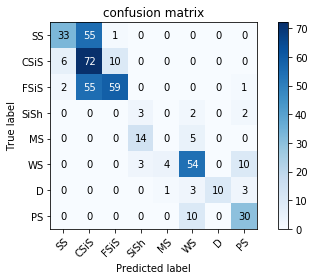

In [0]:
import xgboost as xgb
from xgboost.sklearn import  XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

model = Pipeline([
        ("scaler", StandardScaler()),   
        ("xgboost_clf", XGBClassifier(learning_rate=0.12, max_depth=3, min_child_weight=10, n_estimators=150, seed=10, colsample_bytree=0.9))
    ])

model.fit(X_aug, y_aug)

y_pred =model.predict(X_aug_t)

conf = confusion_matrix(y_aug_t, y_pred)

d=f1_score(y_aug_t, y_pred, average='micro')
print('Optimized facies classification accuracy = %.2f' % d)
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(conf, adjacent_facies))

plot_confusion_matrix(conf)

# Define plot(compare facies)

In [0]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

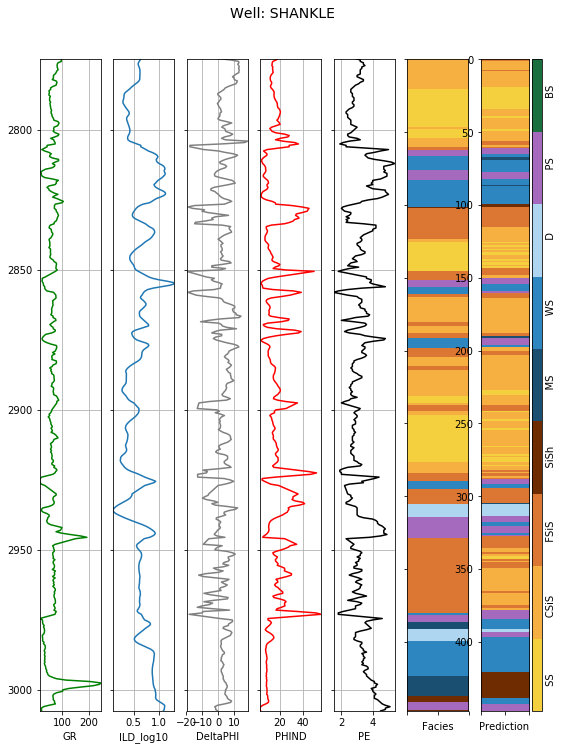

In [0]:
tt=test.drop([448])
tt['Prediction'] = y_pred
compare_facies_plot(tt, 'Prediction', facies_colors)